In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [66]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [67]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [68]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [69]:
len(dataset)

68

In [70]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [71]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[163. 161. 172.]
  [129. 127. 138.]
  [108. 106. 117.]
  ...
  [163. 161. 175.]
  [158. 156. 170.]
  [153. 151. 165.]]

 [[149. 147. 158.]
  [ 98.  96. 107.]
  [144. 142. 153.]
  ...
  [159. 157. 171.]
  [165. 163. 177.]
  [168. 166. 180.]]

 [[100.  98. 109.]
  [117. 115. 126.]
  [188. 186. 199.]
  ...
  [163. 161. 175.]
  [164. 162. 176.]
  [164. 162. 176.]]

 ...

 [[142. 138. 153.]
  [120. 116. 131.]
  [136. 132. 147.]
  ...
  [180. 178. 191.]
  [178. 176. 189.]
  [189. 187. 200.]]

 [[118. 114. 129.]
  [102.  98. 113.]
  [157. 153. 168.]
  ...
  [177. 175. 188.]
  [172. 170. 183.]
  [177. 175. 188.]]

 [[123. 119. 134.]
  [128. 124. 139.]
  [148. 144. 159.]
  ...
  [205. 203. 216.]
  [188. 186. 199.]
  [173. 171. 184.]]]


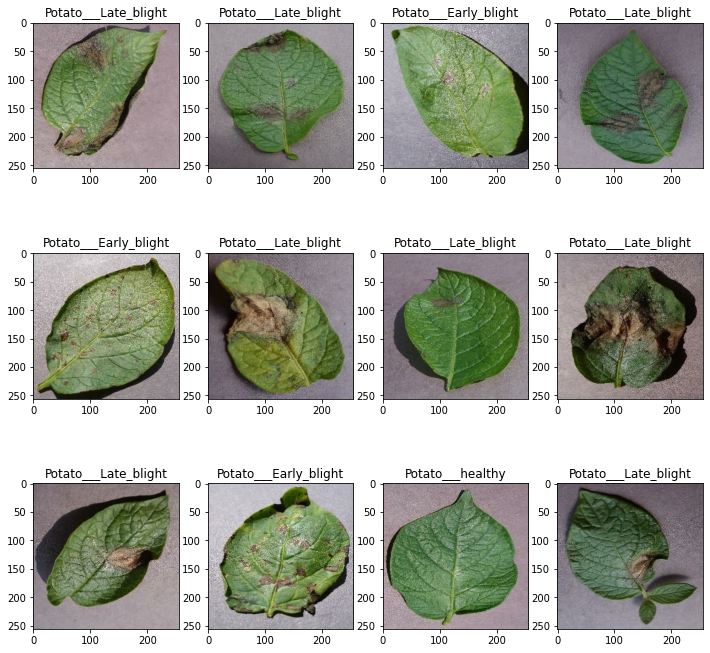

In [72]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [73]:
def dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=500):
    assert(train_split+val_split+test_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=10)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [74]:
train_ds, val_ds, test_ds = dataset_partitions_tf(dataset)

In [75]:
len(train_ds)

54

In [76]:
len(val_ds)

6

In [77]:
len(test_ds)

8

In [78]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [79]:
resize_and_rescale=tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),  
])

In [80]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [81]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [82]:
input_set=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=input_set),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation="relu"),
#     layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])
model.build(input_shape=input_set)

In [83]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_63 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_63 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_64 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (32, 60, 60, 64)        

In [84]:
model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

In [85]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
    )

Epoch 1/50
54/54 [==============================] - 138s 2s/step - loss: 0.8710 - accuracy: 0.5475 - val_loss: 0.6796 - val_accuracy: 0.7135
Epoch 2/50
54/54 [==============================] - 80s 1s/step - loss: 0.6245 - accuracy: 0.7477 - val_loss: 0.3871 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.3843 - accuracy: 0.8451 - val_loss: 0.4072 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 81s 2s/step - loss: 0.3166 - accuracy: 0.8721 - val_loss: 0.2897 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 80s 1s/step - loss: 0.2446 - accuracy: 0.9020 - val_loss: 0.2550 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 79s 1s/step - loss: 0.1915 - accuracy: 0.9184 - val_loss: 0.2130 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 80s 1s/step - loss: 0.1596 - accuracy: 0.9384 - val_loss: 0.1818 - val_accuracy: 0.9531
Epoch 8/50
54/54 [=

In [86]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 35s 413ms/step - loss: 0.0233 - accuracy: 0.9922


In [87]:
history

In [88]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [90]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [91]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

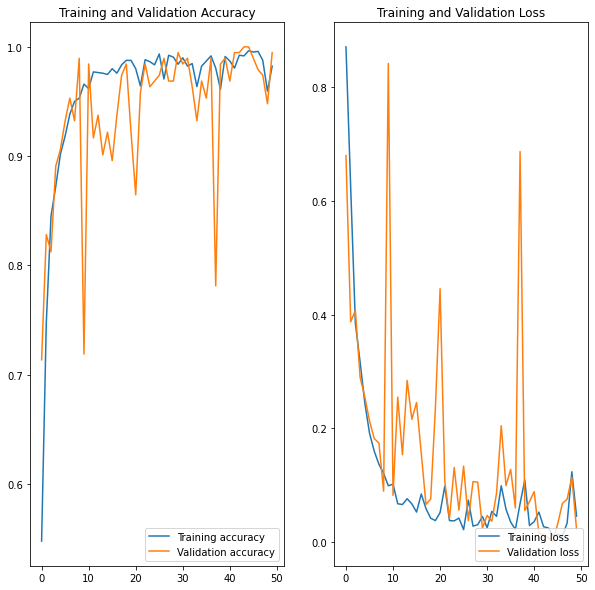

In [93]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training loss")
plt.plot(range(EPOCHS),val_loss,label="Validation loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

first image to predict
Actuale label:  Potato___Late_blight
predicted label:  Potato___Late_blight


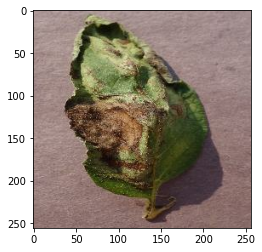

In [96]:
import numpy as py
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("Actuale label: ",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label: ",class_names[py.argmax(batch_prediction[0])])

In [99]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[py.argmax(predictions[0])]
    confidence = round(100 * (py.max(predictions[0])), 2)
    return predicted_class, confidence

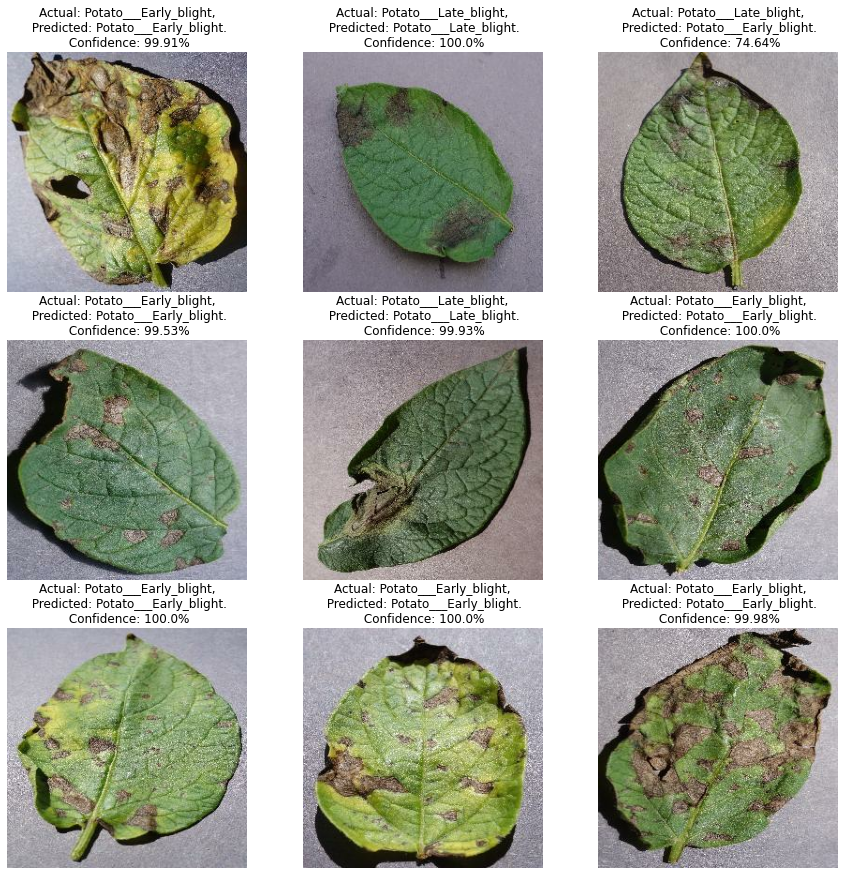

In [100]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [102]:
model_version=1
model.save(f"/models/{model_version}")

INFO:tensorflow:Assets written to: /models/1\assets
